In [55]:
import pandas as pd
import torch
import torch.nn.functional as F
from StockAnomaly import StockAnomaly
import numpy as np
import yfinance as yf


from transformers import (AutoModelForSequenceClassification,
                          pipeline,
                          AutoTokenizer)

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
BERTmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('text-classification',model=BERTmodel,tokenizer=tokenizer,truncation=True, max_length=512)


def finbert_sentiment(text:str) -> tuple[float,float,float,str]:
    '''https://www.youtube.com/watch?v=FRDKeNEeNAQ&t=640s'''
    with torch.no_grad():
 
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512     
        )
        
        inputs = {k: v.to(BERTmodel.device) for k, v in inputs.items()}

        outputs = BERTmodel(**inputs)
        
        probs = F.softmax(outputs.logits, dim=-1).squeeze()
        
        id2label = BERTmodel.config.id2label
        scores = {id2label[i]: probs[i].item() for i in range(len(id2label))}

        return (scores['positive'],scores['neutral'],scores['negative'],max(scores,key=scores.get))

def calc_bullishness(group_series):
    """
    Antweiler & Frank (2004) Bullishness Index: B = ln((1 + N_pos) / (1 + N_neg))
    Input: A Series of sentiment labels ('positive', 'neutral', 'negative')
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    
    return np.log((1 + n_pos) / (1 + n_neg))

def calc_agreement(group_series):
    """
    Antweiler & Frank (2004) Agreement Index:
    Measures consensus. Higher value = High consensus (everyone agrees).
    Lower value = High disagreement or mostly neutral news.
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    n_neut = counts.get('neutral', 0)
    
    total = n_pos + n_neg + n_neut
    
    if total == 0:
        return 0.0
    
    inner_val = ((n_pos - n_neg) / total) ** 2
    agreement = 1 - np.sqrt(1 - inner_val)
    
    return agreement

Device set to use cuda:0


In [56]:
data = pd.read_parquet('scraped_data.parquet')
data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)


/tmp/ipykernel_60165/1598241461.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)


In [57]:
stock_anomaly = StockAnomaly()

stock_anomaly.calculate(window=20,price_z=2,volume_z=2)

tech_crash_events = stock_anomaly.get_anomalies(get_dict_dates=True)

[*********************100%***********************]  5 of 5 completed


In [58]:
data[['fb_positive','fb_neutral','fb_negative','sentiment']] = data['fist_parag'].apply(finbert_sentiment).apply(pd.Series)

In [59]:
metrics = data.groupby(['label','date'],as_index=False)['sentiment'].agg(
    bullishness_index = calc_bullishness,
    agreement_index = calc_agreement,
    article_count = 'count'
)

In [60]:
import yfinance as yf

def add_ts(metrics):
    '''maybe use stockanomaly functions'''
    
    stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]
    stocks_data = yf.Tickers(stocks)
    data = stocks_data.history('5y', interval="1d")['Close']

    prices_long = data.stack().reset_index()

    prices_long.columns = ['date','label','price']

    prices_long.sort_values(['label','date'],inplace=True)

    prices_long['date']=prices_long['date'].dt.date.astype(str)

    combined_df = prices_long.merge(metrics, on=['date', 'label'], how='left')

    return combined_df  

In [61]:
combined_df = add_ts(metrics)

[*********************100%***********************]  5 of 5 completed


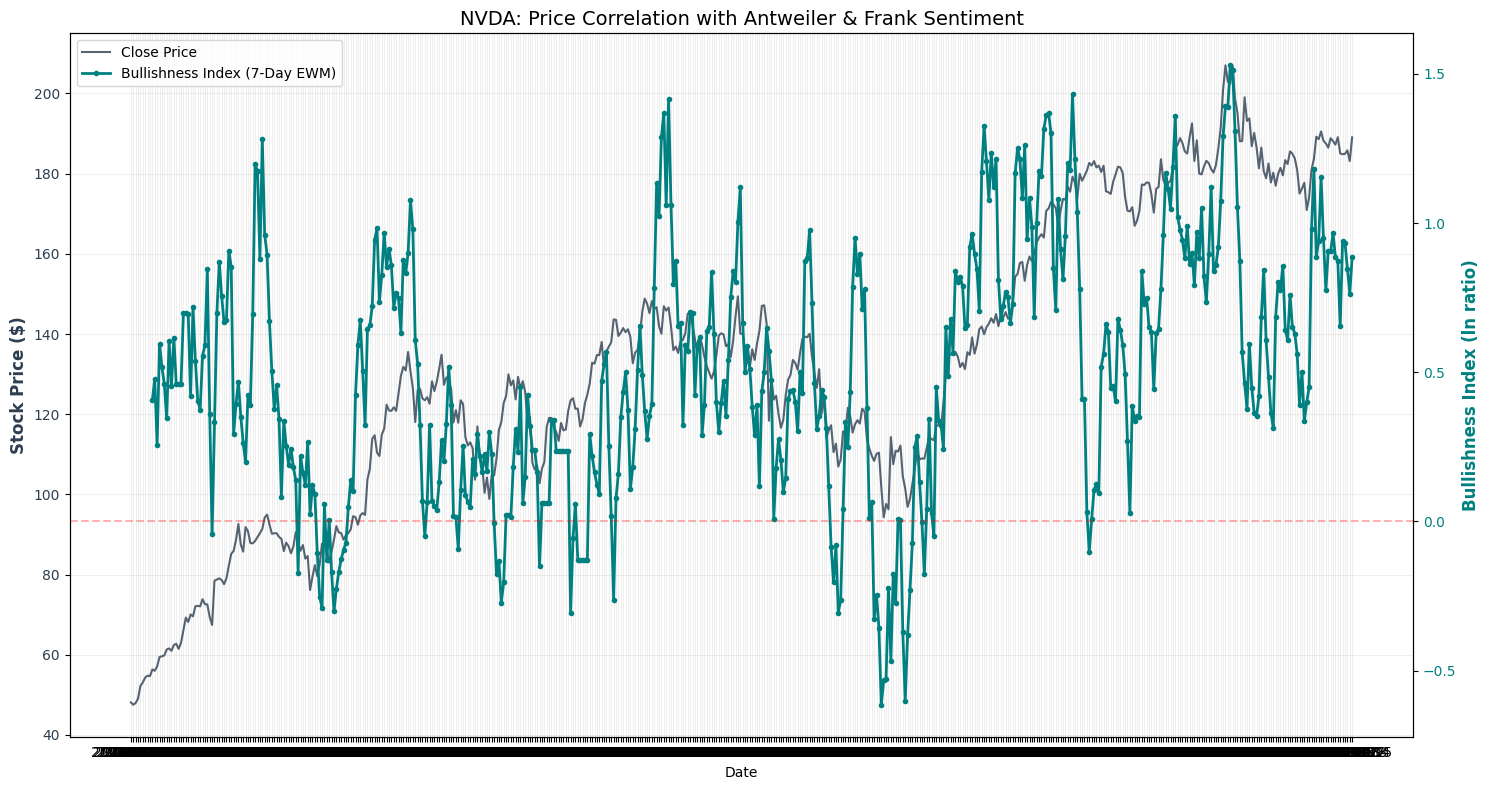

In [62]:
import matplotlib.pyplot as plt

def plot_price_vs_sentiment(df, ticker):
    # Filter for the chosen stock
    stock_df = df[df['label'] == ticker].copy()

    min_date = min((stock_df[['date','bullishness_index']].dropna())['date'])

    stock_df = stock_df[stock_df['date']>='2024-01-01']
    
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # --- LEFT Y-AXIS: PRICE ---
    # Prices are usually continuous, so this line will likely be solid
    color_price = '#2c3e50' # Dark blue-grey
    ax1.plot(stock_df['date'], stock_df['price'], color=color_price, 
             linewidth=1.5, label='Close Price', alpha=0.8)
    
    ax1.set_ylabel('Stock Price ($)', color=color_price, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, alpha=0.2)

    # --- RIGHT Y-AXIS: BULLISHNESS ---
    # This line will break wherever 'bullishness_index' is NaN
    ax2 = ax1.twinx()
    color_bull = '#008080' # Teal
    ax2.plot(stock_df['date'], stock_df['bullishness_index'].ewm(span=7, adjust=False).mean(), color=color_bull, 
             linewidth=2, marker='o', markersize=3, label='Bullishness Index (7-Day EWM)')
    
    ax2.set_ylabel('Bullishness Index (ln ratio)', color=color_bull, fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color_bull)
    
    # Add a horizontal line at 0 for neutral sentiment
    ax2.axhline(0, color='red', linestyle='--', alpha=0.3)

    # Title and Legends
    plt.title(f'{ticker}: Price Correlation with Antweiler & Frank Sentiment', fontsize=14)
    ax1.set_xlabel('Date')
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

    plt.tight_layout()
    plt.show()

# Usage:
plot_price_vs_sentiment(combined_df, 'NVDA')